In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
from collections import defaultdict

In [3]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3162675 sha256=efc82928d87bd7ffc39341cb9f1c3482a88c01f1da58683e6f8dad9c0c2c5203
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [4]:
from surprise import KNNWithMeans
from surprise import SVD, SVDpp
from surprise import KNNBaseline
from surprise import KNNBasic
from surprise import KNNWithZScore
from surprise import BaselineOnly
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise.model_selection import GridSearchCV


In [7]:

df = pd.read_csv("/content/user_preferences.csv")
names=["userId", "ORDERNUMBER", "rating", "ORDERDATE"]

df.head()



,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,POSTALCODE,State,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE,ArtStylePreference,JewelryTypePreference,FavoriteMaterial,PrefersHandcrafted
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,10022,Uttar Pradesh,NaN,Yu,Kwai,Small,Impressionist,Bracelet,Platinum,True
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,...,51100,Maharashtra,EMEA,Henriot,Paul,Small,Surrealist,Bracelet,Silver,False
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,...,75508,Manipur,EMEA,Da Cunha,Daniel,Medium,Impressionist,Bracelet,Wood,False
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,...,90003,Chhattisgarh,NaN,Young,Julie,Medium,Modern,Bracelet,Gold,False
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,...,NaN,Odisha,NaN,Brown,Julie,Medium,Modern,Earrings,Gold,False


In [8]:
rows_count, columns_count = df.shape
print('Total Number of rows :', rows_count)
print('Total Number of columns :', columns_count)

Total Number of rows : 2823
Total Number of columns : 29


In [9]:
df.dtypes

ORDERNUMBER                int64
QUANTITYORDERED            int64
PRICEEACH                float64
ORDERLINENUMBER            int64
SALES                    float64
ORDERDATE                 object
STATUS                    object
QTR_ID                     int64
MONTH_ID                   int64
YEAR_ID                    int64
PRODUCTLINE               object
MSRP                       int64
PRODUCTCODE               object
CUSTOMERNAME              object
PHONE                     object
ADDRESSLINE1              object
ADDRESSLINE2              object
CITY                      object
STATE                     object
POSTALCODE                object
State                     object
TERRITORY                 object
CONTACTLASTNAME           object
CONTACTFIRSTNAME          object
DEALSIZE                  object
ArtStylePreference        object
JewelryTypePreference     object
FavoriteMaterial          object
PrefersHandcrafted          bool
dtype: object

### => Unique UserId and ProductID :-

In [17]:
unique_userId = df['CUSTOMERNAME'].nunique()
unique_productId = df['PRODUCTLINE'].nunique()
print('Total number of unique Users    : ', unique_userId)
print('Total number of unique Products : ', unique_productId)


Total number of unique Users    :  92
Total number of unique Products :  38


<Axes: >

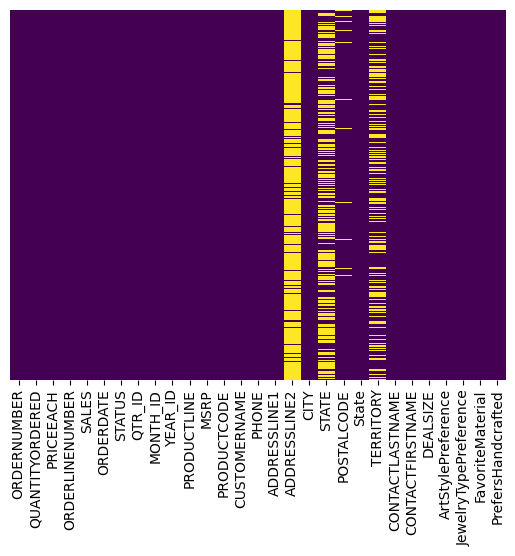

In [18]:
sns.heatmap(df.isna(), yticklabels=False, cbar=False, cmap='viridis')

In [19]:
df.apply(lambda x : sum(x.isnull()))

ORDERNUMBER                 0
QUANTITYORDERED             0
PRICEEACH                   0
ORDERLINENUMBER             0
SALES                       0
ORDERDATE                   0
STATUS                      0
QTR_ID                      0
MONTH_ID                    0
YEAR_ID                     0
PRODUCTLINE                 0
MSRP                        0
PRODUCTCODE                 0
CUSTOMERNAME                0
PHONE                       0
ADDRESSLINE1                0
ADDRESSLINE2             2521
CITY                        0
STATE                    1486
POSTALCODE                 76
State                       0
TERRITORY                1074
CONTACTLASTNAME             0
CONTACTFIRSTNAME            0
DEALSIZE                    0
ArtStylePreference          0
JewelryTypePreference       0
FavoriteMaterial            0
PrefersHandcrafted          0
dtype: int64

In [20]:
df.isnull().sum()

ORDERNUMBER                 0
QUANTITYORDERED             0
PRICEEACH                   0
ORDERLINENUMBER             0
SALES                       0
ORDERDATE                   0
STATUS                      0
QTR_ID                      0
MONTH_ID                    0
YEAR_ID                     0
PRODUCTLINE                 0
MSRP                        0
PRODUCTCODE                 0
CUSTOMERNAME                0
PHONE                       0
ADDRESSLINE1                0
ADDRESSLINE2             2521
CITY                        0
STATE                    1486
POSTALCODE                 76
State                       0
TERRITORY                1074
CONTACTLASTNAME             0
CONTACTFIRSTNAME            0
DEALSIZE                    0
ArtStylePreference          0
JewelryTypePreference       0
FavoriteMaterial            0
PrefersHandcrafted          0
dtype: int64

In [22]:
df.dropna(axis=1, inplace = True)


In [23]:
df_transpose = df.describe().T
df_transpose

,count,mean,std,min,25%,50%,75%,max
ORDERNUMBER,2823.0,10258.725115,92.085478,10100.00,10180.00,10262.0,10333.5,10425.0
QUANTITYORDERED,2823.0,35.092809,9.741443,6.00,27.00,35.0,43.0,97.0
PRICEEACH,2823.0,83.658544,20.174277,26.88,68.86,95.7,100.0,100.0
ORDERLINENUMBER,2823.0,6.466171,4.225841,1.00,3.00,6.0,9.0,18.0
SALES,2823.0,3553.889072,1841.865106,482.13,2203.43,3184.8,4508.0,14082.8
QTR_ID,2823.0,2.717676,1.203878,1.00,2.00,3.0,4.0,4.0
MONTH_ID,2823.0,7.092455,3.656633,1.00,4.00,8.0,11.0,12.0
YEAR_ID,2823.0,2003.815090,0.699670,2003.00,2003.00,2004.0,2004.0,2005.0
MSRP,2823.0,100.715551,40.187912,33.00,68.00,99.0,124.0,214.0


<Axes: >

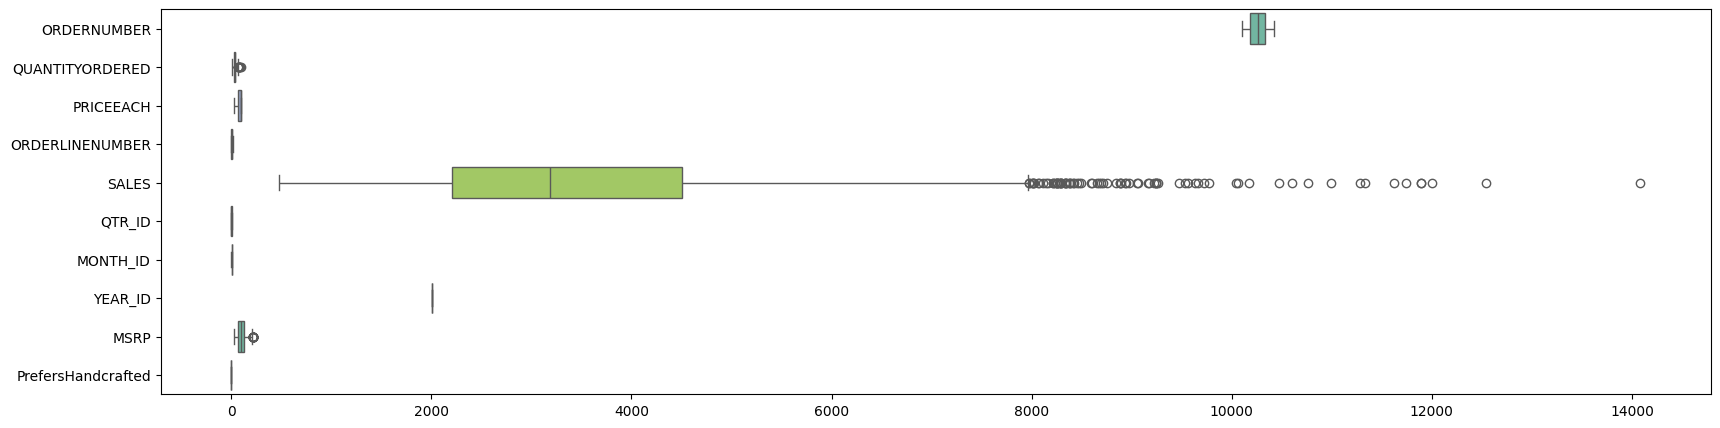

In [25]:
plt.figure(figsize=(20,5))
sns.boxplot(data=df, orient='h', palette='Set2', dodge=False)

In [29]:
df['rating'].value_counts()

5    581
4    572
1    570
3    563
2    537
Name: rating, dtype: int64


In [30]:
df.corr()

<ipython-input-30-2f6f6606aa2c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,QTR_ID,MONTH_ID,YEAR_ID,MSRP,PrefersHandcrafted
ORDERNUMBER,1.000000,0.065543,-0.002935,-0.055550,0.039919,-0.051383,-0.039723,0.904596,-0.010280,-0.001867
QUANTITYORDERED,0.065543,1.000000,0.005564,-0.018397,0.551426,-0.035323,-0.039048,0.069535,0.017881,0.001733
PRICEEACH,-0.002935,0.005564,1.000000,-0.020965,0.657841,0.008712,0.005152,-0.005938,0.670625,-0.022103
ORDERLINENUMBER,-0.055550,-0.018397,-0.020965,1.000000,-0.058400,0.040716,0.034016,-0.057367,-0.021067,-0.007036
SALES,0.039919,0.551426,0.657841,-0.058400,1.000000,-0.006796,-0.009605,0.035647,0.635239,-0.032867
QTR_ID,-0.051383,-0.035323,0.008712,0.040716,-0.006796,1.000000,0.979300,-0.433052,0.010234,0.027158
MONTH_ID,-0.039723,-0.039048,0.005152,0.034016,-0.009605,0.979300,1.000000,-0.430163,0.008170,0.025452
YEAR_ID,0.904596,0.069535,-0.005938,-0.057367,0.035647,-0.433052,-0.430163,1.000000,-0.014310,-0.012818
MSRP,-0.010280,0.017881,0.670625,-0.021067,0.635239,0.010234,0.008170,-0.014310,1.000000,-0.022181
PrefersHandcrafted,-0.001867,0.001733,-0.022103,-0.007036,-0.032867,0.027158,0.025452,-0.012818,-0.022181,1.000000


<ipython-input-31-ec64fb401e3d>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.zeros_like(df.corr(), dtype=np.bool)
<ipython-input-31-ec64fb401e3d>:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(df.corr(), dtype=np.bool)
<ipython-input-31-ec64fb401e3d>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this war

<Axes: title={'center': 'Correlation of Attributes'}>

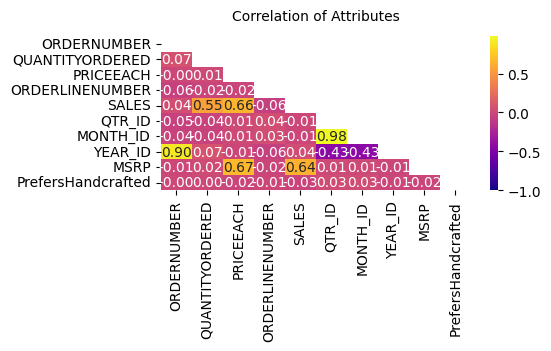

In [31]:
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(5,2))
plt.title('Correlation of Attributes', y=1.05, size=10)
sns.heatmap(df.corr(),vmin=-1, cmap='plasma',annot=True,  mask=mask, fmt='.2f')

In [33]:
df1 = df.copy()

In [34]:
df1.head()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,CITY,State,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE,ArtStylePreference,JewelryTypePreference,FavoriteMaterial,PrefersHandcrafted
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NYC,Uttar Pradesh,Yu,Kwai,Small,Impressionist,Bracelet,Platinum,True
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,Reims,Maharashtra,Henriot,Paul,Small,Surrealist,Bracelet,Silver,False
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,Paris,Manipur,Da Cunha,Daniel,Medium,Impressionist,Bracelet,Wood,False
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,...,78934 Hillside Dr.,Pasadena,Chhattisgarh,Young,Julie,Medium,Modern,Bracelet,Gold,False
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,...,7734 Strong St.,San Francisco,Odisha,Brown,Julie,Medium,Modern,Earrings,Gold,False


In [ ]:
users_counts = df1['userId'].value_counts().rename('users_counts')
users_data   = df1.merge(users_counts.to_frame(),
                                left_on='userId',
                                right_index=True)

In [39]:

essential_columns = [
    'CUSTOMERNAME',
    'ORDERNUMBER',
    'ArtStylePreference',
    'JewelryTypePreference',
    'FavoriteMaterial',
    'PrefersHandcrafted'
]

df_new = df[essential_columns]

df_new.rename(columns={
    'CUSTOMERNAME': 'userId',
    'ORDERNUMBER': 'productId'
}, inplace=True)

df_new.head()


<ipython-input-39-2d19013a0104>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.rename(columns={


,userId,productId,ArtStylePreference,JewelryTypePreference,FavoriteMaterial,PrefersHandcrafted
0,Land of Toys Inc.,10107,Impressionist,Bracelet,Platinum,True
1,Reims Collectables,10121,Surrealist,Bracelet,Silver,False
2,Lyon Souveniers,10134,Impressionist,Bracelet,Wood,False
3,Toys4GrownUps.com,10145,Modern,Bracelet,Gold,False
4,Corporate Gift Ideas Co.,10159,Modern,Earrings,Gold,False


In [40]:
k = 5

In [41]:
reader = Reader(rating_scale=(1, 5))

In [42]:
surprise_data = Dataset.load_from_df(df_new[['userId', 'productId', 'PrefersHandcrafted']], reader)

In [43]:
trainset, testset = train_test_split(surprise_data, test_size=.30, random_state=7)

In [48]:
panda_data.groupby('productId')['rating'].mean().head()

productId
B00001P4XA    4.000000
B00001P4ZH    4.470588
B00001WRSJ    4.500000
B00001ZWXA    4.600000
B00004SABB    4.000000
Name: rating, dtype: float64


In [51]:
prod_rating_count = pd.DataFrame(panda_data.groupby('productId')['rating'].mean().sort_values(ascending=False))
prod_rating_count['prod_rating_count'] = pd.DataFrame(panda_data.groupby('productId')['rating'].count())
prod_rating_count.head(k)

productId	rating	prod_rating_count
B00L3YHF6O	5.0	14
B00006HSML	5.0	10
B001TH7GUA	5.0	17
B000IJY8DS	5.0	17
B005LDLP8W	5.0	16


In [52]:
basic_poplurity_model = prod_rating_count.sort_values(by=['prod_rating_count'], ascending=False)
basic_poplurity_model.head(k)

productId	rating	prod_rating_count
B0088CJT4U	4.218447	206
B003ES5ZUU	4.864130	184
B000N99BBC	4.772455	167
B007WTAJTO	4.701220	164
B00829TIEK	4.436242	149


 </b> Above is the list of top 5 popular products for the recommendation.

In [53]:
cv_results = []

In [55]:
svd_param_grid = {'n_epochs': [20, 25], 'lr_all': [0.007, 0.009, 0.01], 'reg_all': [0.4, 0.6]}

svd_gs = GridSearchCV(SVD, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
svdpp_gs = GridSearchCV(SVDpp, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)

svd_gs.fit(surprise_data)
svdpp_gs.fit(surprise_data)


print(svd_gs.best_score['rmse'])
print(svdpp_gs.best_score['rmse'])

print(svd_gs.best_params['rmse'])
print(svdpp_gs.best_params['rmse'])

0.7011565174490746
0.7010180300607086
{'n_epochs': 20, 'lr_all': 0.007, 'reg_all': 0.4}
{'n_epochs': 20, 'lr_all': 0.007, 'reg_all': 0.4}


these are the best parameters for the SVD an SVDpp algorithm

### =>  SVD :-

In [57]:
start_time = time.time()


svd_model = SVD(n_epochs=20, lr_all=0.005, reg_all=0.2)


svd_model.fit(trainset)



predictions_svd = svd_model.test(testset)


svd_cv = cross_validate(svd_model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


svd_df = pd.DataFrame.from_dict(svd_cv)
svd_described = svd_df.describe()
cv_results = pd.DataFrame([['SVD', svd_described['test_rmse']['mean'], svd_described['test_mae']['mean'],
                           svd_described['fit_time']['mean'], svd_described['test_time']['mean']]],
                            columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])


print("\n\n==================== Model Evaluation ===============================")
accuracy.rmse(predictions_svd, verbose=True)
print("=====================================================================")
computational_time = time.time() - start_time
print('\n Computational Time : %0.3fs' %(computational_time))
cv_results

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7152  0.6938  0.6836  0.6970  0.7158  0.7011  0.0126  
MAE (testset)     0.5115  0.4814  0.4673  0.4858  0.5124  0.4917  0.0177  
Fit time          0.05    0.05    0.05    0.05    0.14    0.07    0.04    
Test time         0.01    0.01    0.01    0.01    0.02    0.01    0.00    


==================== Model Evaluation ===============================
RMSE: 0.7033

 Computational Time : 0.528s


,Model,RMSE,MAE,Fit Time,Test Time
0,SVD,0.701086,0.491681,0.068154,0.007221


K-NN algorithm

In [59]:
start_time = time.time()

knn_param_grid = {'bsl_options': {'method': ['als', 'sgd'],
                              'reg': [1, 2]},
              'k': [15, 20, 25, 30, 40, 50, 60],
              'sim_options': {'name': ['msd', 'cosine', 'pearson_baseline']}
              }

knnbasic_gs = GridSearchCV(KNNBasic, knn_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
knnmeans_gs = GridSearchCV(KNNWithMeans, knn_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
knnz_gs     = GridSearchCV(KNNWithZScore, knn_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)


knnbasic_gs.fit(surprise_data)
knnmeans_gs.fit(surprise_data)
knnz_gs.fit(surprise_data)


print(knnbasic_gs.best_score['rmse'])
print(knnmeans_gs.best_score['rmse'])
print(knnz_gs.best_score['rmse'])


print(knnbasic_gs.best_params['rmse'])
print(knnmeans_gs.best_params['rmse'])
print(knnz_gs.best_params['rmse'])



0.7011899609023552
0.7010149122714072
0.7010588445991226
{'bsl_options': {'method': 'als', 'reg': 1}, 'k': 15, 'sim_options': {'name': 'msd', 'user_based': True}}
{'bsl_options': {'method': 'als', 'reg': 1}, 'k': 15, 'sim_options': {'name': 'msd', 'user_based': True}}
{'bsl_options': {'method': 'als', 'reg': 1}, 'k': 15, 'sim_options': {'name': 'msd', 'user_based': True}}


In [64]:
fit_time_cv = [round(res['fit_time'].mean(), 4) for res in all_algos_cv]
test_time_cv = [round(res['test_time'].mean(), 4) for res in all_algos_cv]
results_df = pd.DataFrame({
    'Model': x_algo,
    'RMSE': rmse_cv,
    'MAE': mae_cv,
    'Fit Time': fit_time_cv,
    'Test Time': test_time_cv
})
print(results_df)

	Model		RMSE		MAE		Fit Time	Test Time
0	SVD		0.874827	0.646240	2.038448	0.071078
1	KNNBasic	0.870367	0.643615	25.973961	0.361971


using SVD algorithm to get the top 5 recommendations of new products for each user

In [65]:
top_n = defaultdict(list)
def get_top_n(predictions, n=k):

    top_n = defaultdict(list)


    user_ratings.sort(key=lambda x: x[1], reverse=True)
    top_n[uid] = user_ratings[:n]

    return top_n

top_n = get_top_n(predictions_svd, n=k)
top_n

[10265, 10133, 10241, 10206, 10212]
